# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: {YOUR NAMES}  
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils

torch.manual_seed(42) # Set manual seed

In [39]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [40]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

In [41]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=False, transform=test_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform=train_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.
data_train = train_dataset.data/255
data_test = test_dataset.data/255

# dictionary with means and standard deviations
dict = {'Mean (Train)': list(data_train.mean(axis = (0,1,2))),
        'Mean (Test)': list(data_test.mean(axis = (0,1,2))),
        'Standard deviation (Train)': list(data_train.std(axis = (0,1,2))),
        'Standard deviation (Test)': list(data_test.std(axis = (0,1,2)))}

# dictionary to dataframe
df = pd.DataFrame(data=dict)

# show dataframe
display(df)

# Size of sets
print(f'Shape of training set: {train_dataset.data.shape}') # images, height, width, color channels
print(f'Shape of test set:     {test_dataset.data.shape}')  # 10000 images, 32px, 32px, 3 color channels (RGB)


,Mean (Train),Mean (Test),Standard deviation (Train),Standard deviation (Test)
0,0.491400,0.494214,0.247032,0.246653
1,0.482158,0.485131,0.243485,0.242892
2,0.446531,0.450409,0.261588,0.261592


Shape of training set: (50000, 32, 32, 3)
Shape of test set:     (10000, 32, 32, 3)


In [42]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=batch_size) 

In [43]:
## TODO: plot images with their labels after augmentations
def show_batch(dl):
    images, labels = next(iter(dl))

    # Create a grid of normalized images
    grid = utils.make_grid(images, nrow=16, padding=12, normalize=True)

    # Transpose the grid (color channels should be in the last position)
    grid = np.transpose(grid, (1, 2, 0))
    
    # Define class labels
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Plot the grid of images
    plt.figure(figsize=(16, 16)) # 16 * 16 = 256
    plt.imshow(grid)
    plt.axis('off')

    # Define label position offsets
    x_offset = 28
    y_offset = 51  # Fixed vertical offset below the grid

    # Display the labels below each image
    for i in range(256):
        x = i % 16 * 44 + x_offset
        y = (i // 16) * 44 + y_offset
        plt.text(x, y, class_labels[labels[i]], color='black', backgroundcolor='white', fontsize=8, ha='center')
        
    plt.show()

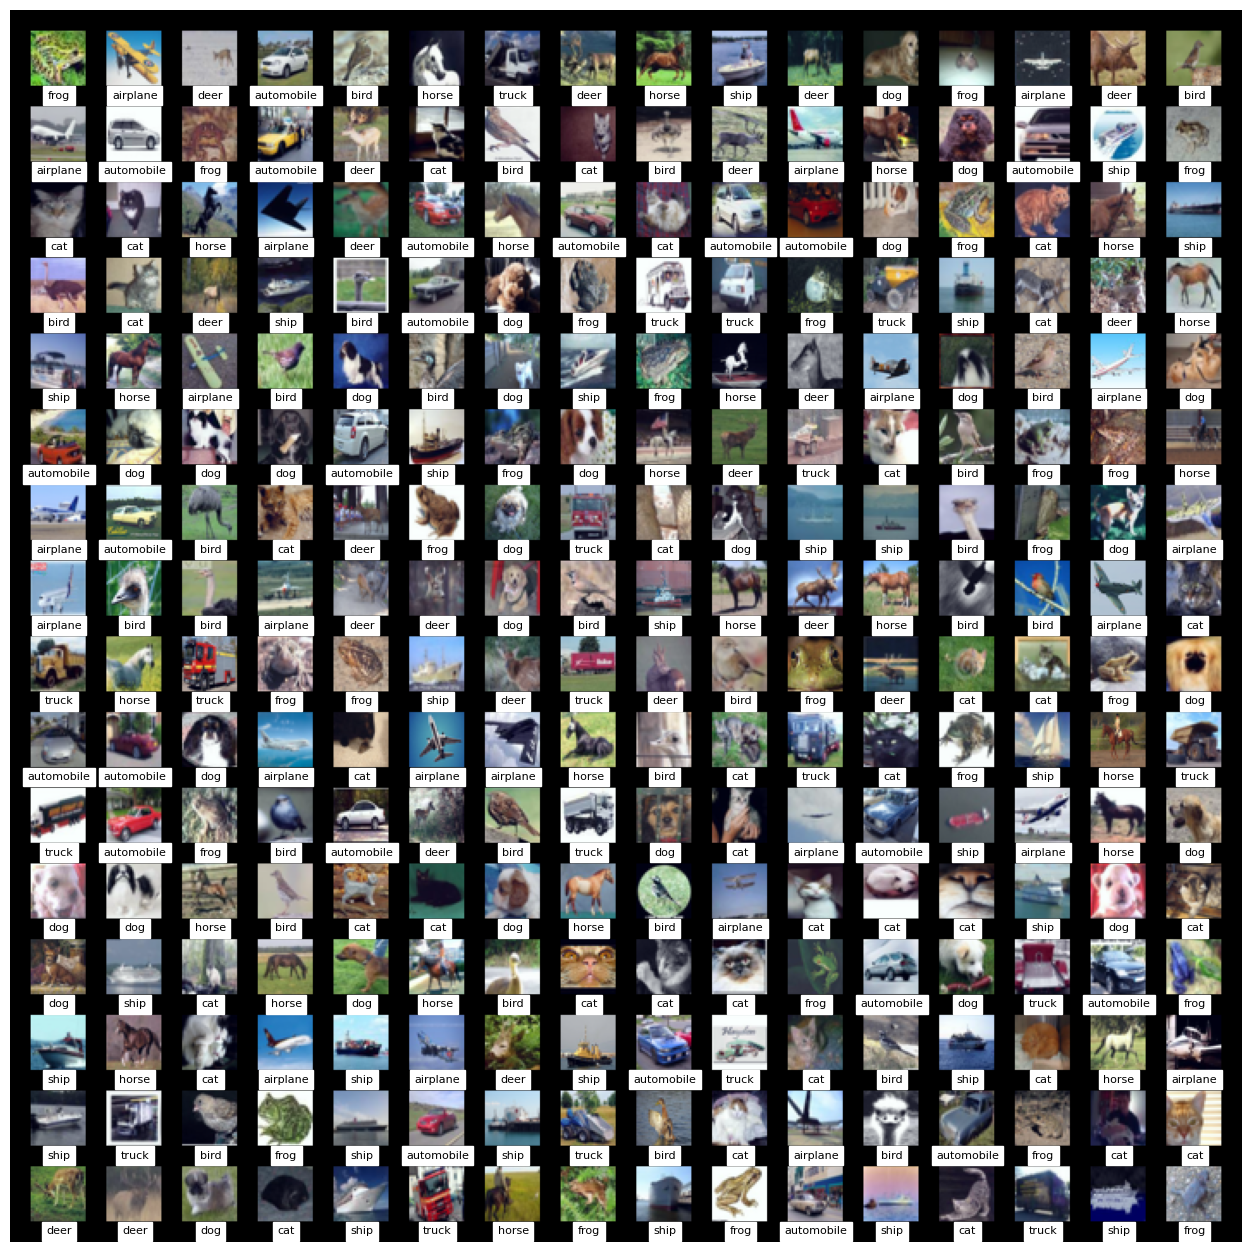

In [44]:
show_batch(train_loader)

In [51]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [46]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    ratio = correct/total

    return ratio

In [52]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 

# excluded master_bar as it is not relevant for our function

def train(dataloader, optimizer, model, loss_fn, device):
    """ method to train the model """

    # TODO: refine the training function from above
  # it should contain:
  # - saving of losses
  # - calculation of accuracy
  # - returning the mean loss and accuracy

    model.train()  
    train_loss = 0.0
    
    for i, (x, y) in enumerate(dataloader):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model.forward(x)
        
        loss = loss_fn(y_pred.squeeze(), y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(dataloader)
    
    return train_loss


def validate(dataloader, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    

In [48]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch

In [49]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    

## Logistic Regression   

In [50]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO: define linear layer for the model
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO: flatten the input to a suitable size for the initial layer
        
        # TODO: run the data through the layer
        outputs = # TODO:
        return outputs

SyntaxError: invalid syntax (2425154428.py, line 18)

In [ ]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
linear_regression = 


In [ ]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [ ]:
# TODO: define the loss function


In [ ]:
num_epochs = 20
## TODO: run training over 20 epochs


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        ## TODO: Make the 4 layer MLP with the following shapes :
        ## input_dim -> 1650 -> 512 -> 138 -> output_dim
        ## Use RELu as nonlinearity

        super().__init__()
        
        
    def forward(self, xb):
        ## TODO: write the forward pass
        ## Do not forget to flatten the input

        return 

In [ ]:
## TODO: Define network, put it to device and train mode


In [ ]:
## TODO: Define optimizer and loss functions


In [ ]:
## TODO: Train the MLP over 20 epochs


## Add L2 regularisation

In [ ]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength

In [ ]:
## TODO: Retrain new model with regularization over 20 epochs

## LeNet5

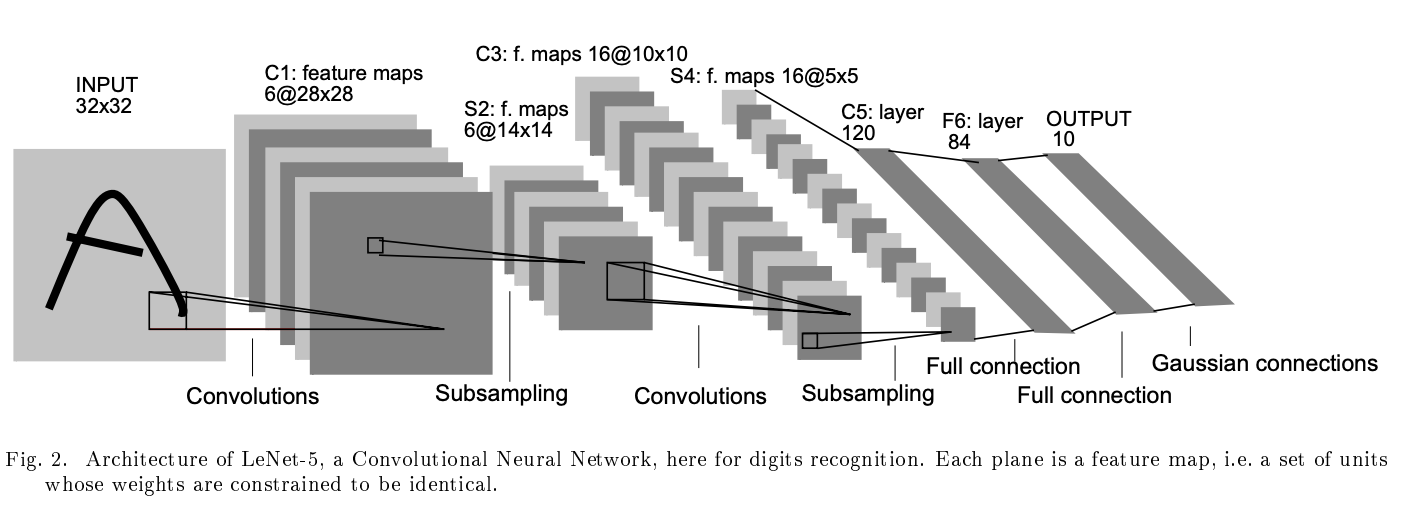

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
    
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
## TODO: define network, put it to the device and train mode


In [ ]:
## TODO: define loss function and optimisers


In [ ]:
## TODO: train with 20 epochs
num_epochs = 20


## Analysis 

In [ ]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

In [ ]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?

In [ ]:
## TODO: Plot the confusion matrix for LeNet5


## Questions
* How did regularization change the performance of the MLP? Why?
* Explain the confusion matrix for LeNet5. What do you see there?
* Explain the difference in peformance between linear regression, MLP, and LeNet5.
* Why are convolutions better suited for pictures? Which properties of images do they exploit?
* Is it important to redefine an optimizer for each different model, training? What about loss functions?

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
